# Exercises & Extra-curriculum

In [63]:
import torch
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons
import sklearn 
from sklearn.model_selection import train_test_split
from torch import nn
import torchmetrics
from helper_functions import plot_decision_boundary, plot_predictions

In [64]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### **1.** Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [65]:
# Create dataset 
SEED = 42
N_SAMPLES = 1000
X, y = make_moons(n_samples=N_SAMPLES,
                  random_state=SEED,
                  noise=0.07)

# Turn into PyTorch tensors
X = torch.from_numpy(X).type(dtype=torch.float)
y = torch.from_numpy(y).type(dtype=torch.float).unsqueeze(dim=1)

# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train.dtype, y_train.dtype

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 1]),
 torch.float32,
 torch.float32)

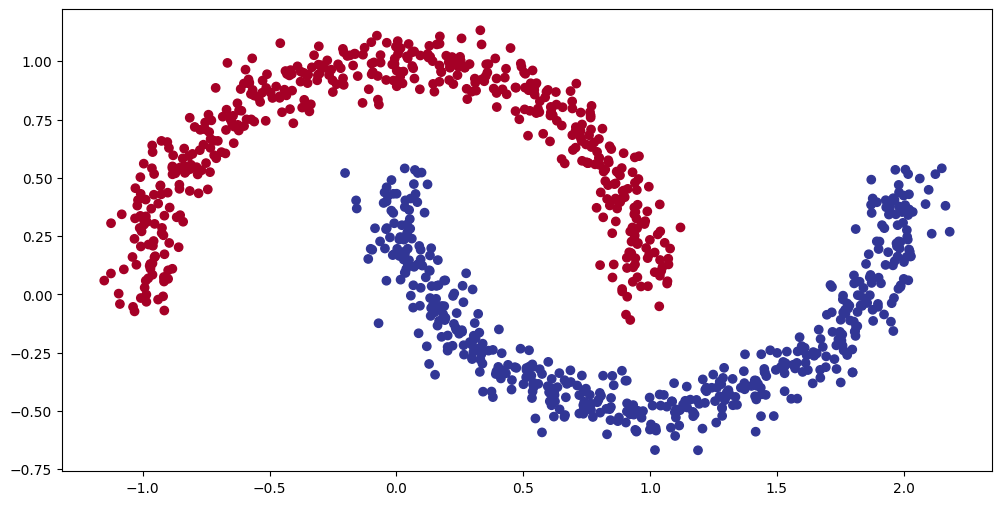

In [66]:
# Visualize 
plt.figure(figsize=(12, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

#### **2.** Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [67]:
# Model 
class MoonClassificationModelV0(nn.Module):
    def __init__(self, in_f, out_f, hidd_units):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features=in_f, out_features=hidd_units),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidd_units, out_features=hidd_units),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidd_units, out_features=out_f))
                
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.layer(X)
    
model = MoonClassificationModelV0(in_f=2,
                                  out_f=1,
                                  hidd_units=10).to(device)
model, next(model.parameters())
            

(MoonClassificationModelV0(
   (layer): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): ReLU()
     (2): Linear(in_features=10, out_features=10, bias=True)
     (3): ReLU()
     (4): Linear(in_features=10, out_features=1, bias=True)
   )
 ),
 Parameter containing:
 tensor([[ 0.1408,  0.6085],
         [-0.6846,  0.5381],
         [ 0.2230,  0.0450],
         [ 0.4124,  0.1503],
         [ 0.0887,  0.4615],
         [ 0.1855, -0.4671],
         [-0.3641, -0.6372],
         [ 0.4577, -0.0243],
         [-0.0364,  0.4321],
         [-0.3795,  0.6394]], device='cuda:0', requires_grad=True))

#### **3.** Setup a binary classification compatible loss function and optimizer to use when training the model.

In [68]:
# Loss and optimizer 
loss_fn = torch.nn.BCEWithLogitsLoss() # input: logits, sigmoid built-in
optim = torch.optim.SGD(params=model.parameters(),
                        lr=0.1)

#### **4.** Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [69]:
# Epochs 
epochs = 1000

# Acc function
acc_fn = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)

# Agnostic code 
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_train.device, X_test.device, y_train.device, y_test.device, next(model.parameters())

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 Parameter containing:
 tensor([[ 0.1408,  0.6085],
         [-0.6846,  0.5381],
         [ 0.2230,  0.0450],
         [ 0.4124,  0.1503],
         [ 0.0887,  0.4615],
         [ 0.1855, -0.4671],
         [-0.3641, -0.6372],
         [ 0.4577, -0.0243],
         [-0.0364,  0.4321],
         [-0.3795,  0.6394]], device='cuda:0', requires_grad=True))

In [70]:
# Train & test loop 
for epoch in range(epochs):
    model.train()
    
    logits = model(X_train)
    pred = torch.round(torch.sigmoid(logits))
    
    loss = loss_fn(logits, y_train)
    acc = acc_fn(pred, y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if epoch % 10 == 0:
        with torch.inference_mode():
            model.eval()
            test_logits = model(X_test)
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_pred, y_test)
            test_acc = acc_fn(test_pred, y_test)
            print(f"Epoch: {epoch} | Train: [{acc:.2f}, {loss:.4f}] | Test: [{test_acc:.2f}, {test_loss:.4f}]")

Epoch: 0 | Train: [0.50, 0.6956] | Test: [0.50, 0.6931]
Epoch: 10 | Train: [0.50, 0.6777] | Test: [0.50, 0.6931]
Epoch: 20 | Train: [0.53, 0.6553] | Test: [0.54, 0.6799]
Epoch: 30 | Train: [0.72, 0.6257] | Test: [0.73, 0.6058]
Epoch: 40 | Train: [0.82, 0.5881] | Test: [0.80, 0.5792]
Epoch: 50 | Train: [0.86, 0.5445] | Test: [0.83, 0.5683]
Epoch: 60 | Train: [0.87, 0.4995] | Test: [0.84, 0.5676]
Epoch: 70 | Train: [0.86, 0.4579] | Test: [0.85, 0.5674]
Epoch: 80 | Train: [0.86, 0.4222] | Test: [0.83, 0.5798]
Epoch: 90 | Train: [0.86, 0.3921] | Test: [0.84, 0.5760]
Epoch: 100 | Train: [0.86, 0.3672] | Test: [0.84, 0.5784]
Epoch: 110 | Train: [0.87, 0.3464] | Test: [0.86, 0.5739]
Epoch: 120 | Train: [0.87, 0.3291] | Test: [0.86, 0.5739]
Epoch: 130 | Train: [0.87, 0.3148] | Test: [0.86, 0.5739]
Epoch: 140 | Train: [0.87, 0.3029] | Test: [0.86, 0.5732]
Epoch: 150 | Train: [0.88, 0.2930] | Test: [0.86, 0.5763]
Epoch: 160 | Train: [0.88, 0.2846] | Test: [0.86, 0.5763]
Epoch: 170 | Train: [0.88

#### **5.** Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

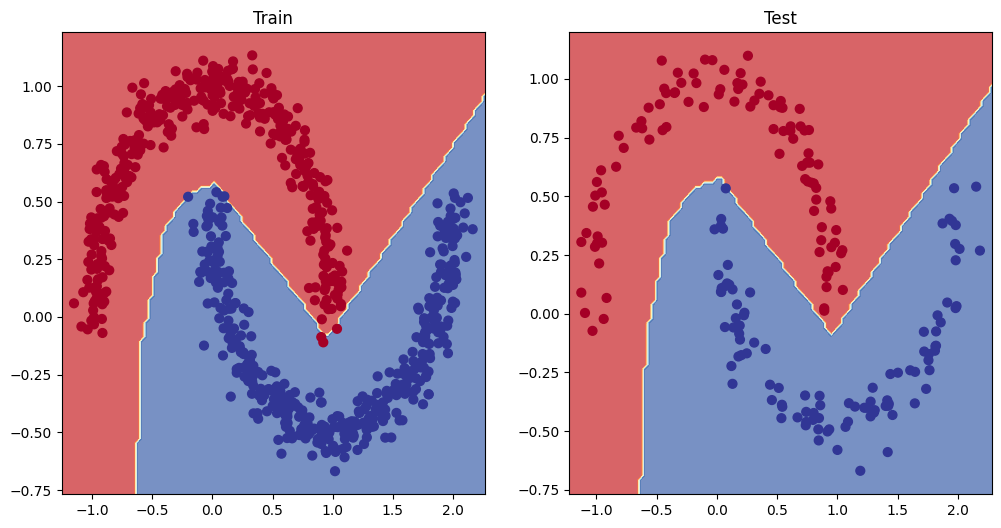

In [71]:
# Plot decision boundary 
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_decision_boundary(model, X_train, y_train)
plt.title("Train")
plt.subplot(1,2,2)
plot_decision_boundary(model, X_test, y_test)
plt.title("Test")
plt.show()

#### **6.** Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.


In [72]:
def tanh(X:torch.Tensor) -> torch.Tensor:
    return (torch.exp(X) - torch.exp(-X)) / (torch.exp(X) + torch.exp(-X)) 

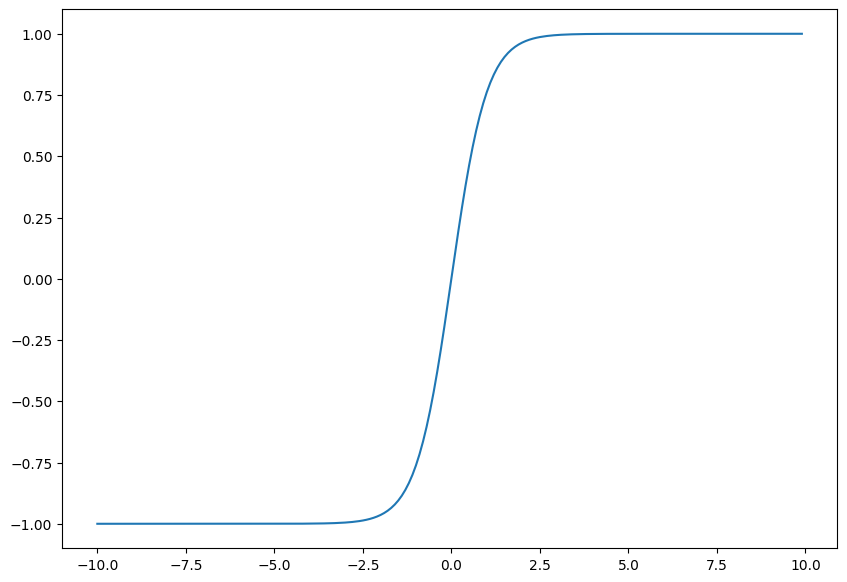

In [73]:
# Torch version
A = torch.arange(-10, 10, 0.1)
B = torch.tanh(A)
plt.figure(figsize=(10,7))
plt.plot(A, B)
plt.show()

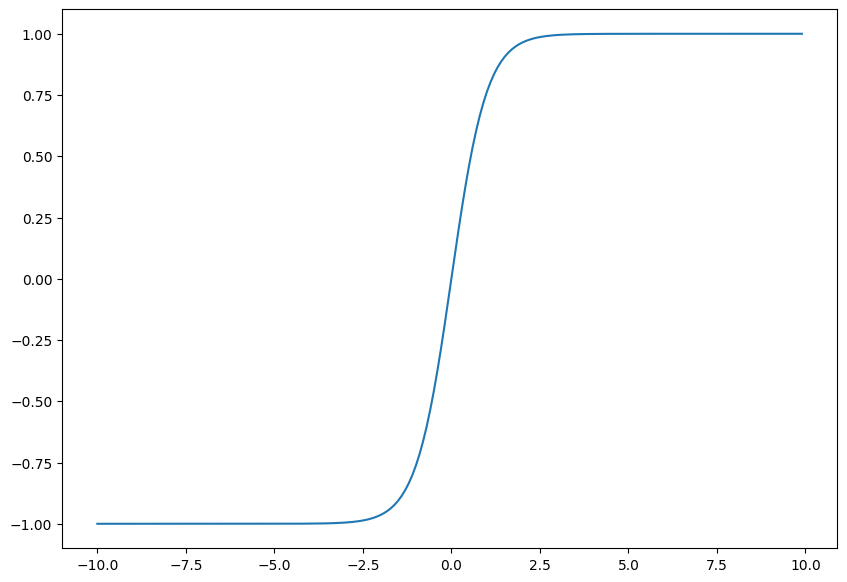

In [74]:
# Example 
A = torch.arange(-10, 10, 0.1)
B = tanh(A)
plt.figure(figsize=(10, 7))
plt.plot(A, B)
plt.show()

#### **7.** Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

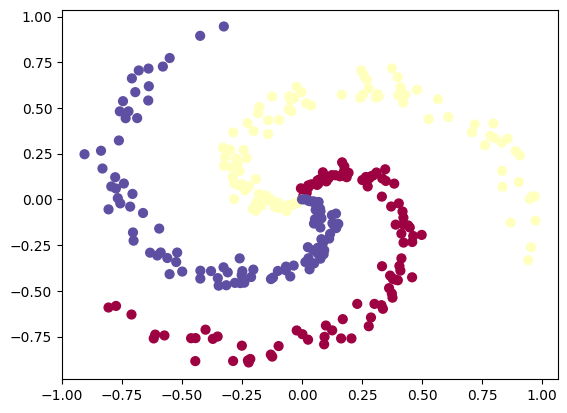

In [75]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [76]:
np.unique(y) # 3 Clases 

array([0, 1, 2], dtype=uint8)

In [90]:
# Model
class SpiralModel(nn.Module):
    def __init__(self, in_f, out_f, hidd_u) -> None:
        super().__init__()
        
        self.layer = nn.Sequential(nn.Linear(in_features=in_f, out_features=hidd_u),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidd_u, out_features=hidd_u),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidd_u, out_features=out_f))
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer(x)
    
model_2 = SpiralModel(in_f=2, out_f=3, hidd_u=10).to(device)

In [78]:
# Loss & optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model_2.parameters(),
                         lr=0.1)
acc_fn = torchmetrics.Accuracy(task="multiclass",
                               num_classes=3).to(device)
# Torch tensor 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.int64).unsqueeze(dim=1)
X.shape, y.shape, X.dtype, y.dtype

(torch.Size([300, 2]), torch.Size([300, 1]), torch.float32, torch.int64)

In [79]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2)
# To device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
if y_train.dim() > 1: y_train = y_train.squeeze()
if y_test.dim() > 1 : y_test = y_test.squeeze()
X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [80]:
# Prediction 
with torch.inference_mode():
    model_2.eval()
    logits = model_2(X_train)
    pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    print(f"Logits:\n{logits[:5]}")
    print(f"Prediction:\n{pred[:5]}")
    print(f"Real labels:\n{y_train[:5]}")

Logits:
tensor([[ 0.0647,  0.1945, -0.1296],
        [ 0.0479,  0.2172, -0.1301],
        [ 0.0644,  0.1945, -0.1406],
        [ 0.0630,  0.1988, -0.1546],
        [ 0.0618,  0.1979, -0.1593]], device='cuda:0')
Prediction:
tensor([1, 1, 1, 1, 1], device='cuda:0')
Real labels:
tensor([0, 2, 2, 1, 1], device='cuda:0')


In [81]:
print("logits:", logits.shape, logits.dtype, logits.device)
print("y_train:", y_train.shape, y_train.dtype, y_train.device)
print("logits.ndim, y_train.ndim:", logits.ndim, y_train.ndim)

logits: torch.Size([240, 3]) torch.float32 cuda:0
y_train: torch.Size([240]) torch.int64 cuda:0
logits.ndim, y_train.ndim: 2 1


In [82]:
# Loop
epochs = 1000

for epoch in range(epochs):
    model_2.train()
    
    logits = model_2(X_train) # Devuelve un (,N)
    pred = torch.argmax(torch.softmax(logits, dim=1), dim=1) # Devuelve (,N)
    
    loss = loss_fn(logits, y_train) # Aqui tienen que tener el mismo shape
    acc = acc_fn(pred, y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if epoch % 20 == 0:
        with torch.inference_mode():
            model_2.eval()
            test_logits = model_2(X_test)
            test_pred = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
            
            test_loss = loss_fn(test_logits, y_test)
            test_acc = acc_fn(test_pred, y_test)
            
            print(f"Epoch: {epoch} | Train: [{acc:.2}, {loss:.4f}] | Test: [{test_acc:.2f}, {test_loss:.4f}]")

Epoch: 0 | Train: [0.35, 1.1062] | Test: [0.35, 1.1023]
Epoch: 20 | Train: [0.82, 0.4649] | Test: [0.78, 0.4699]
Epoch: 40 | Train: [0.97, 0.1099] | Test: [0.95, 0.1380]
Epoch: 60 | Train: [0.99, 0.0306] | Test: [0.95, 0.0853]
Epoch: 80 | Train: [1.0, 0.0177] | Test: [0.97, 0.0685]
Epoch: 100 | Train: [1.0, 0.0129] | Test: [0.97, 0.0659]
Epoch: 120 | Train: [1.0, 0.0104] | Test: [0.97, 0.0649]
Epoch: 140 | Train: [1.0, 0.0089] | Test: [0.97, 0.0650]
Epoch: 160 | Train: [1.0, 0.0077] | Test: [0.97, 0.0664]
Epoch: 180 | Train: [1.0, 0.0067] | Test: [0.97, 0.0683]
Epoch: 200 | Train: [1.0, 0.0059] | Test: [0.97, 0.0707]
Epoch: 220 | Train: [1.0, 0.0052] | Test: [0.97, 0.0735]
Epoch: 240 | Train: [1.0, 0.0046] | Test: [0.97, 0.0767]
Epoch: 260 | Train: [1.0, 0.0041] | Test: [0.97, 0.0800]
Epoch: 280 | Train: [1.0, 0.0036] | Test: [0.97, 0.0835]
Epoch: 300 | Train: [1.0, 0.0032] | Test: [0.97, 0.0872]
Epoch: 320 | Train: [1.0, 0.0028] | Test: [0.97, 0.0912]
Epoch: 340 | Train: [1.0, 0.0025]

In [84]:
print(test_pred.shape, y_test.shape)

torch.Size([60]) torch.Size([60])


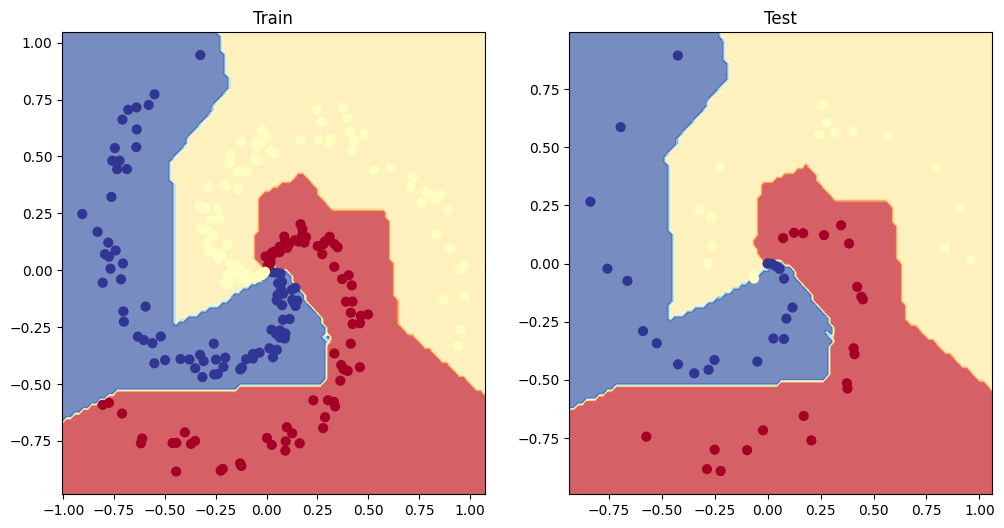

In [85]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_2, X_train, y_train)
plt.title("Train")
plt.subplot(1,2,2)
plot_decision_boundary(model_2, X_test, y_test)
plt.title("Test")
plt.show()


In [94]:
with torch.inference_mode():
    model_2.eval()
    logits = model_2(X_train)
    pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)

print(f"X_train: {X_train.shape} | logits: {logits.shape} | pred: {pred.shape}")

X_train: torch.Size([240, 2]) | logits: torch.Size([240, 3]) | pred: torch.Size([240])
